# Make sure Colab Hardware accelerator is set to :T4 GPU


In [ ]:
import time
start_time = time.time()

In [ ]:
!git clone https://github.com/openai/point-e.git

fatal: destination path 'point-e' already exists and is not an empty directory.


In [ ]:
!pip install point-e/

Processing ./point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-_dizuic8/clip_e14e7d51c111499ca15c311e9983d3c1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-_dizuic8/clip_e14e7d51c111499ca15c311e9983d3c1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for point-e: filename=point_e-0.0.0-py3-none-any.whl size=49735 sha256=653d895891b795042bf6cf26f0d1c631b86560bcad3abff2f7eec3c1f3524453
  Stored in directory: /root/.cache/pip/wheels/30/f2/b8/7216ff37009da3656f0a6751c69bd7fb3850484df3b787ec56
Successfully built point-e
  Attempting uninstall: point-e
    Found existing installation: point-e 0.0.0
    Uninstalling point-e-0.0.0:
      Successfully uninstalled point-e-0.0.0


# Text to Point cloud

In [ ]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''),
)

In [ ]:
# Set a prompt to condition on.
prompt = 'a green rabbit'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

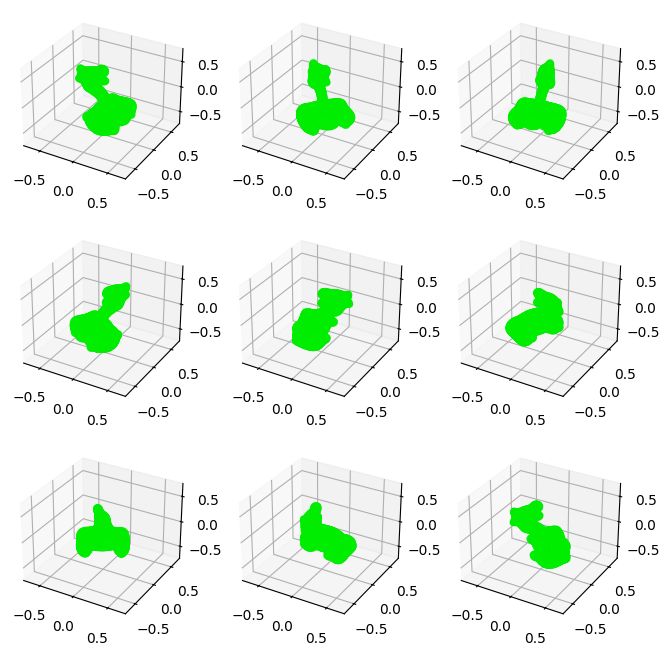

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
!pip install plyfile

In [ ]:
# Convert to ply file for rendering in MeshLab

import numpy as np
points = pc.coords  # Shape (N, 3)
red = pc.channels['R']  # Shape (N,)
green = pc.channels['G']  # Shape (N,)
blue = pc.channels['B']  # Shape (N,)

# Ensure RGB values are in [0, 255] (if they're in [0, 1])
red = (red * 255).astype(np.uint8)
green = (green * 255).astype(np.uint8)
blue = (blue * 255).astype(np.uint8)

from plyfile import PlyData, PlyElement

# Combine points and colors into a structured array
vertices = np.empty(points.shape[0], dtype=[
    ('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
    ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')
])
vertices['x'] = points[:, 0]
vertices['y'] = points[:, 1]
vertices['z'] = points[:, 2]
vertices['red'] = red
vertices['green'] = green
vertices['blue'] = blue

# Create and save the PLY file
ply_element = PlyElement.describe(vertices, 'vertex')
PlyData([ply_element], text=False).write('point_cloud.ply')

# Image 2 Point cloud

In [ ]:
print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [ ]:
# Load an image to condition on.
img = Image.open('point-e/point_e/examples/example_data/corgi.jpg')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

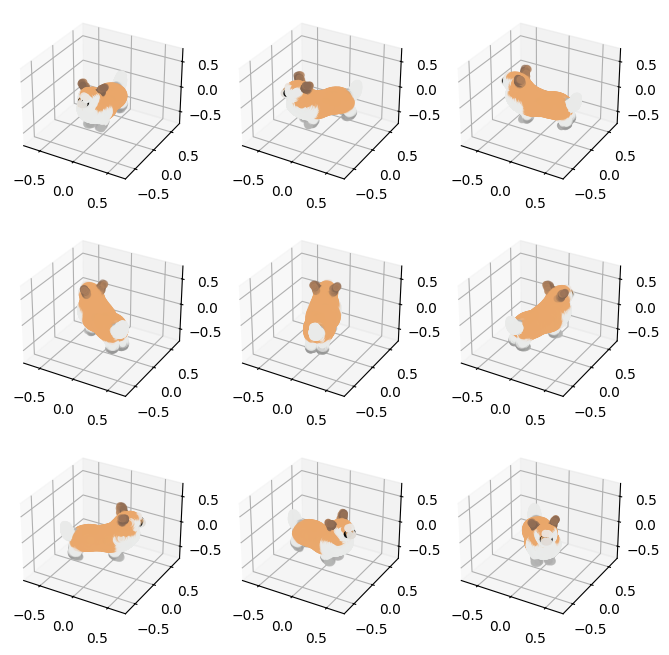

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

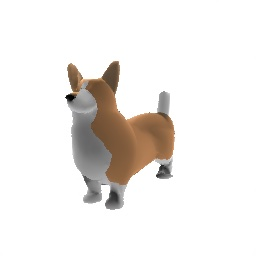

In [ ]:
from IPython.display import Image as show_Image
show_Image('point-e/point_e/examples/example_data/corgi.jpg')

In [ ]:
end_time = time.time()
print(f"Time taken: {int(end_time - start_time)} seconds")

Time taken: 270 seconds
